In [6]:
from jupyter_map_gl import GlMap
from IPython.display import display
import requests
import json
import os
import threading


layers = [{
    'id': 'dg',
    'type': 'footprint',
    'geojson': {'features': []},
    'props': {
        'fill': '#00B2EE',
        'stroke': '#BFEFFF'
    }}]

glmap = GlMap(props={
     'width': 1000, 
     'height': 400,
     'latitude': 30.0,
     'longitude': 0.0,
     'zoom': 1,
     'tileSource': 'https://cartodb-basemaps-b.global.ssl.fastly.net/dark_all/{z}/{x}/{y}@2x.png',
     'layers': layers })

display(glmap)


def idaho_stream(config={"fromDate": "2015-01-01"}):
    r = requests.post('http://idaho.timbr.io/filter', json=config, stream=True)
    g = r.iter_lines()
    return g

def start(start, end, delay=None):
    stream = idaho_stream(config={"fromDate": start, "toDate": end})

    def fn():
        for msg in stream:
            glmap.add_features('dg', [json.loads(msg)])
        
    thread = threading.Thread(target=fn)
    thread.start()


start("2015-01-01", "2015-01-05")

In [9]:
from collections import defaultdict

chips = defaultdict(list)
for f in glmap.features:
    p = f['properties']
    chips[p['idahoID']].append(p)
    
for k, p in chips.iteritems():
    print k, len(p)

76c25451-4f0a-4b99-b118-f98331224d40 35
1c0c44fd-d92f-4d49-a2bf-3152ced84c56 14
1e7a38a3-2635-4a2d-9838-a6fe5de8d621 21
2af24ba8-a222-4252-abf9-4de86f38da73 16
96204b95-d164-423b-91eb-a646a4b78279 55
3763803f-1551-4ab9-8cee-5f534691e0f6 32


In [10]:
import requests
import os
import rasterio
from rasterio.merge import merge
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

def get_chip_url(mid, zxy):
    base = "http://idaho.geobigdata.io/v1/tile/idaho-images/{}".format(mid)
    return "{}/{}?bands=0,1,2,3,4,5,6,7&format=tif&token={}".format(
        base, '/'.join(map(str,[zxy[2],zxy[0],zxy[1]])), gbdx.gbdx_connection.access_token)

def get_chip(name, mid, data, outdir):
    url = get_chip_url(mid, data['zxy'])
    path = os.path.join(outdir, name+'.tif')
    wgs84 = os.path.join(outdir, name+'_wgs84.tif')
    
    if not os.path.exists(path):
        print 'Retrieving Chip', path
        r = requests.get(url)
        if r.status_code == 200:
            with open(path, 'wb') as the_file:
                the_file.write(r.content)
        else:
            print('There was a problem retrieving IDAHO Image', url)
            r.raise_for_status()

        # georef the file 
        bounds = data['bounds']
        cmd = "gdal_translate -of GTiff -a_ullr {} {} {} {} -a_srs EPSG:4326 {} {}".format(bounds[0], bounds[3], bounds[2], bounds[1], path, wgs84)
        os.system(cmd) 
    return wgs84


def fetch_chips(idaho_id, chips):
    img_dir = os.path.join(os.environ.get('HOME','./'), 'gbdx', 'idaho', idaho_id)

    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    
    return [get_chip('{}_{}'.format(idaho_id,i), idaho_id, t, img_dir) for i,t in enumerate(chips[idaho_id])]

def merge_chips(idaho_id, files):
    sources = [rasterio.open(f) for f in files]
    dest, output_transform = merge(sources)

    profile = sources[0].profile
    profile['transform'] = output_transform
    profile['height'] = dest.shape[1]
    profile['width'] = dest.shape[2]
    profile['driver'] = 'GTiff'

    img_dir = os.path.join(os.environ.get('HOME','./'), 'gbdx', 'idaho', idaho_id)
    output = img_dir + '/merge.tif'
    with rasterio.open(output, 'w', **profile) as dst:
        dst.write(dest)
    return output


def stretch(rgb):
    lims = np.percentile(rgb,(2,98),axis=(0,1))
    for x in xrange(len(rgb[0,0,:])):
        top = lims[:,x][1]
        bottom = lims[:,x][0]
        rgb[:,:,x] = (rgb[:,:,x]-bottom)/float(top-bottom)
    return np.clip(rgb,0,1)
    
def render(tif, w=7, h=7):
    with rasterio.drivers():
        with rasterio.open(merged) as src:
            b, g, r = src.read([2,3,5], masked=True).astype(np.float32)

    rgb = stretch(np.dstack([r,g,b]))
    
    fig, ax = plt.subplots(1, figsize=(w,h), facecolor='white')
    ax.axis('off')
    #rgb[ rgb == 0.0 ] = 1
    imgplot = plt.imshow(rgb)
    plt.show() 

    
def create_index(tif_path, index_type):
 
    def _calculate(NIR, Red, SWIR=None, Green=None):
        if index_type == 'NDVI':
            return (NIR - Red)/(NIR + Red)
        elif index_type == 'NDWI':
            return (Green - NIR)/(Green + NIR)
        elif index_type == 'NBR':
            return  (NIR - SWIR)/(NIR + SWIR)
        else: # SAVI
            return ((NIR - Red)/(NIR + Red + 0.5)) * (1 + 0.5)
    
    with rasterio.drivers():
        with rasterio.open(merged) as src:
           b, g, r, nir = src.read([2,3,5,7], masked=True).astype(np.float32)
        
    index = _calculate(nir, r, Green=g) 
    rgb = stretch(np.dstack([r,g,b]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10), facecolor='white')
    ax1.axis('off')
    ax2.axis('off')
    ax1.imshow(index)
    ax2.imshow(rgb)
    plt.show() 

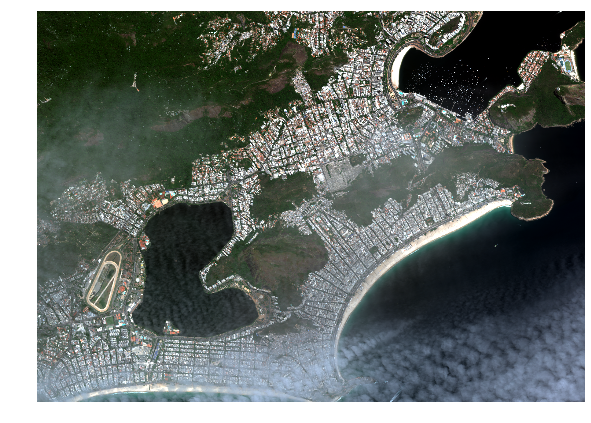

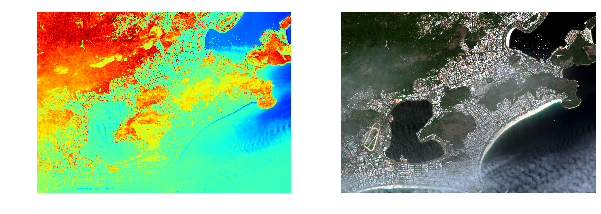

In [12]:
from gbdxtools import Interface
gbdx = Interface()

# select the image id 
idaho_id = chips.keys()[0]

# fetch all the tiles to the local disk
files = fetch_chips(idaho_id, chips)

# merge all the files into one tif
merged = merge_chips(idaho_id, files)

# Visualize
render(merged, w=10)
create_index(merged, 'NDVI')